# 0) Setup environment

In [1]:
!pip install pandas scikit-learn seaborn

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from scipy.stats.contingency import association
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.colors as mcolors
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [3]:
# Impose a seed for reproducibility
random_seed = 421

# 1) Dataset description and minor cleaning

### 1.A) Dataset source

The dataset has been obtained from Kaggle *Mushroom Classification* dataset [1] (licensed under CC0: Public Domain).

[1] [https://www.kaggle.com/datasets/uciml/mushroom-classification](https://www.kaggle.com/datasets/uciml/mushroom-classification)

### 1.B) Dataset content

The purpose of the dataset is to determine whether a mushroom is either *edible* or *poisonous* using classification approaches. The dataset contains **8124 samples**, each sample is labelled as being either **edible or poisonous**, and contains **22 categorical features** that characterize, e.g., its smell, shape, and color.

In [4]:
# Load the dataset (the original CSV file is available from Kaggle)
csv_filename = 'mushrooms.csv'
df = pd.read_csv(csv_filename)
df.shape

(8124, 23)

In [5]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [6]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### 1.C) Minor cleaning of the dataset

Here we perform minor preliminary actions to make the dataset easier and more meaningful to work with.

In [7]:
# Require that all columns to be displayed on screen
pd.options.display.max_columns = df.shape[1]

In [8]:
# Use more explicit names for the categorical features
df['class'] = df['class'].replace({'e': 'edible', 'p': 'poisonous'})
df['cap-shape'] = df['cap-shape'].replace({'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'})
df['cap-surface'] = df['cap-surface'].replace({'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'})
df['cap-color'] = df['cap-color'].replace({'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'})
df['bruises'] = df['bruises'].replace({'t': 'Yes', 'f': 'No'})
df['odor'] = df['odor'].replace({'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy'})
df['gill-attachment'] = df['gill-attachment'].replace({'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'})
df['gill-spacing'] = df['gill-spacing'].replace({'c': 'close', 'w': 'crowded', 'd': 'distant'})
df['gill-size'] = df['gill-size'].replace({'b': 'broad', 'n': 'narrow'})
df['gill-color'] = df['gill-color'].replace({'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'})
df['stalk-shape'] = df['stalk-shape'].replace({'e': 'enlarging', 't': 'tapering'})
df['stalk-root'] = df['stalk-root'].replace({'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing'})
df['stalk-surface-above-ring'] = df['stalk-surface-above-ring'].replace({'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'})
df['stalk-surface-below-ring'] = df['stalk-surface-below-ring'].replace({'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'})
df['stalk-color-above-ring'] = df['stalk-color-above-ring'].replace({'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'})
df['stalk-color-below-ring'] = df['stalk-color-below-ring'].replace({'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'})
df['veil-type'] = df['veil-type'].replace({'p': 'partial', 'u': 'universal'})
df['veil-color'] = df['veil-color'].replace({'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'})
df['ring-number'] = df['ring-number'].replace({'n': 'none', 'o': 'one', 't': 'two'})
df['ring-type'] = df['ring-type'].replace({'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone'})
df['spore-print-color'] = df['spore-print-color'].replace({'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'})
df['population'] = df['population'].replace({'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary'})
df['habitat'] = df['habitat'].replace({'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'u': 'urban', 'w': 'waste', 'd': 'woods'})
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,Yes,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,Yes,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,Yes,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,Yes,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,No,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses


In [9]:
# Detect whether some features have only a single value
print(df.nunique()==1)

class                       False
cap-shape                   False
cap-surface                 False
cap-color                   False
bruises                     False
odor                        False
gill-attachment             False
gill-spacing                False
gill-size                   False
gill-color                  False
stalk-shape                 False
stalk-root                  False
stalk-surface-above-ring    False
stalk-surface-below-ring    False
stalk-color-above-ring      False
stalk-color-below-ring      False
veil-type                    True
veil-color                  False
ring-number                 False
ring-type                   False
spore-print-color           False
population                  False
habitat                     False
dtype: bool


&#x1F4A1; *We observe that the feature `veil-type` is only described by a single value (namely, `partial`). We should therefore drop this feature from the dataframe because it does not contribute to the classification task.*

In [10]:
# Drop features having only a single value, because such feature are irrelevant for the classification task
df = df.drop(['veil-type'], axis=1)

In [11]:
# We ascertain that the classes are balanced
df['class'].value_counts()

class
edible       4208
poisonous    3916
Name: count, dtype: int64

&#x1F4A1; There are nearly as many `edible` and `poisonous` samples, the dataset is well balanced.

# 2) Main objective of the analysis

The object of this analysis is to automatically and adequately classify mushroom samples as either being `edible` or `poisonous`, using several categorical features that describe the appearance or habitat of each mushroom.

# 3) Dataset exploration and preparation

Here we take further actions to examine the dataset in more details, and we apply some modifications to facilitate the main objective of the analysis.

### 3.1) Useful functions

In [12]:
# Define a function to compute the crosstab, the Chi-squared, and the Crammer's V index
def get_crosstab_chisquared_crammerv(data_1, data_2):
    crosstab = pd.crosstab(data_1, data_2)
    chi_squared = chi2_contingency(crosstab)[0]    
    cramer_v = np.sqrt((chi_squared / crosstab.sum().sum()) / (min(crosstab.shape) - 1))
    return crosstab, chi_squared, cramer_v

### 3.2) Detection of features values that should be regrouped

&#x1F4A1; Here we screen the dataset to identify whether some features values are systematically allocated to describe only the same target.

**Example, considering the feature `veil-color`:**

* There are four distinct values: `brown`, `orange`, `white`, `yellow`.
* The value `white` is allocated to describe samples from both `edible` and `poisonous` classes, it is therefore a relevant value.
* The value `yellow` is only allocated to describe samples from the `edible` class, it is therefore a relevant value.
* The values `brown` and `orange` are only allocated to describe samples from the `poisonous` class. We should therefore create a new value called `brown_orange`, regrouping all instances from `brown` and `orange`.

In [13]:
# Identify features having at least one zero-value for either the 'edible' or 'poisonous' class
for index in range(df.shape[1] -1):
    crosstab, _, _ = get_crosstab_chisquared_crammerv(df.iloc[:, 0], df.iloc[:, index +1])
    print(crosstab.eq(0))

# Regroup features that have at least two zero-values for either the 'edible' or 'poisonous' class
df['cap-color'] = df['cap-color'].replace(['green', 'purple'], 'green_purple')
df['odor'] = df['odor'].replace(['almond', 'anise'], 'almond_anise')
df['odor'] = df['odor'].replace(['creosote', 'fishy', 'foul', 'musty', 'pungent', 'spicy'], 'foul_et_al')
df['gill-color'] = df['gill-color'].replace(['buff', 'green'], 'buff_green')
df['gill-color'] = df['gill-color'].replace(['red', 'orange'], 'red_orange')
df['stalk-color-above-ring'] = df['stalk-color-above-ring'].replace(['buff', 'cinnamon', 'yellow'], 'buff_cinnamon_yellow')
df['stalk-color-above-ring'] = df['stalk-color-above-ring'].replace(['gray', 'orange', 'red'], 'gray_orange_red')
df['stalk-color-below-ring'] = df['stalk-color-below-ring'].replace(['buff', 'cinnamon', 'yellow'], 'buff_cinnamon_yellow')
df['stalk-color-below-ring'] = df['stalk-color-below-ring'].replace(['gray', 'orange', 'red'], 'gray_orange_red')
df['veil-color'] = df['veil-color'].replace(['brown', 'orange'], 'brown_orange')
df['ring-type'] = df['ring-type'].replace(['large', 'none'], 'large_none')
df['spore-print-color'] = df['spore-print-color'].replace(['buff', 'orange', 'purple', 'yellow'], 'buff_orange_purple_yellow')
df['population'] = df['population'].replace(['abundant', 'numerous'], 'abundant_numerous')

# Verify that no feature has more than one zero-value for either the 'edible' or 'poisonous' class
for index in range(df.shape[1] -1):
    crosstab, _, _ = get_crosstab_chisquared_crammerv(df.iloc[:, 0], df.iloc[:, index +1])
    print(crosstab.eq(0).sum(axis=1)>1)

cap-shape   bell  conical  convex   flat  knobbed  sunken
class                                                    
edible     False     True   False  False    False   False
poisonous  False    False   False  False    False    True
cap-surface  fibrous  grooves  scaly  smooth
class                                       
edible         False     True  False   False
poisonous      False    False  False   False
cap-color  brown   buff  cinnamon   gray  green   pink  purple    red  white  \
class                                                                          
edible     False  False     False  False  False  False   False  False  False   
poisonous  False  False     False  False   True  False    True  False  False   

cap-color  yellow  
class              
edible      False  
poisonous   False  
bruises       No    Yes
class                  
edible     False  False
poisonous  False  False
odor       almond  anise  creosote  fishy   foul  musty   none  pungent  spicy
class       

### 3.3) Selection of the most relevant features

&#x1F4A1; Here we quantify the association between each feature and the ground-truth class (`edible` or `poisonous`). Because features are categorical, we use the Cramér's V index, which returns a value of `0` if the two compared set of values show a purely random association, and a value of `1` if the two compared set of values are purely associated. We retain all features with an index superior to `0.5` and we therefore select the eight following features:
* `odor`
* `spore-print-color`
* `gill-color`
* `ring-type`
* `stalk-surface-above-ring`
* `stalk-surface-below-ring`
* `stalk-color-above-ring`
* `stalk-color-below-ring`

In [14]:
# Calculate the Cramer's V index for each feature against the target, and sort by decreasing value
cramer_v = np.zeros(df.shape[1] -1)
for index in range(df.shape[1] -1):
    _, _, cramer_v[index] = get_crosstab_chisquared_crammerv(df.iloc[:, 0], df.iloc[:, index +1])
descending_indices = np.flip(np.argsort(cramer_v))

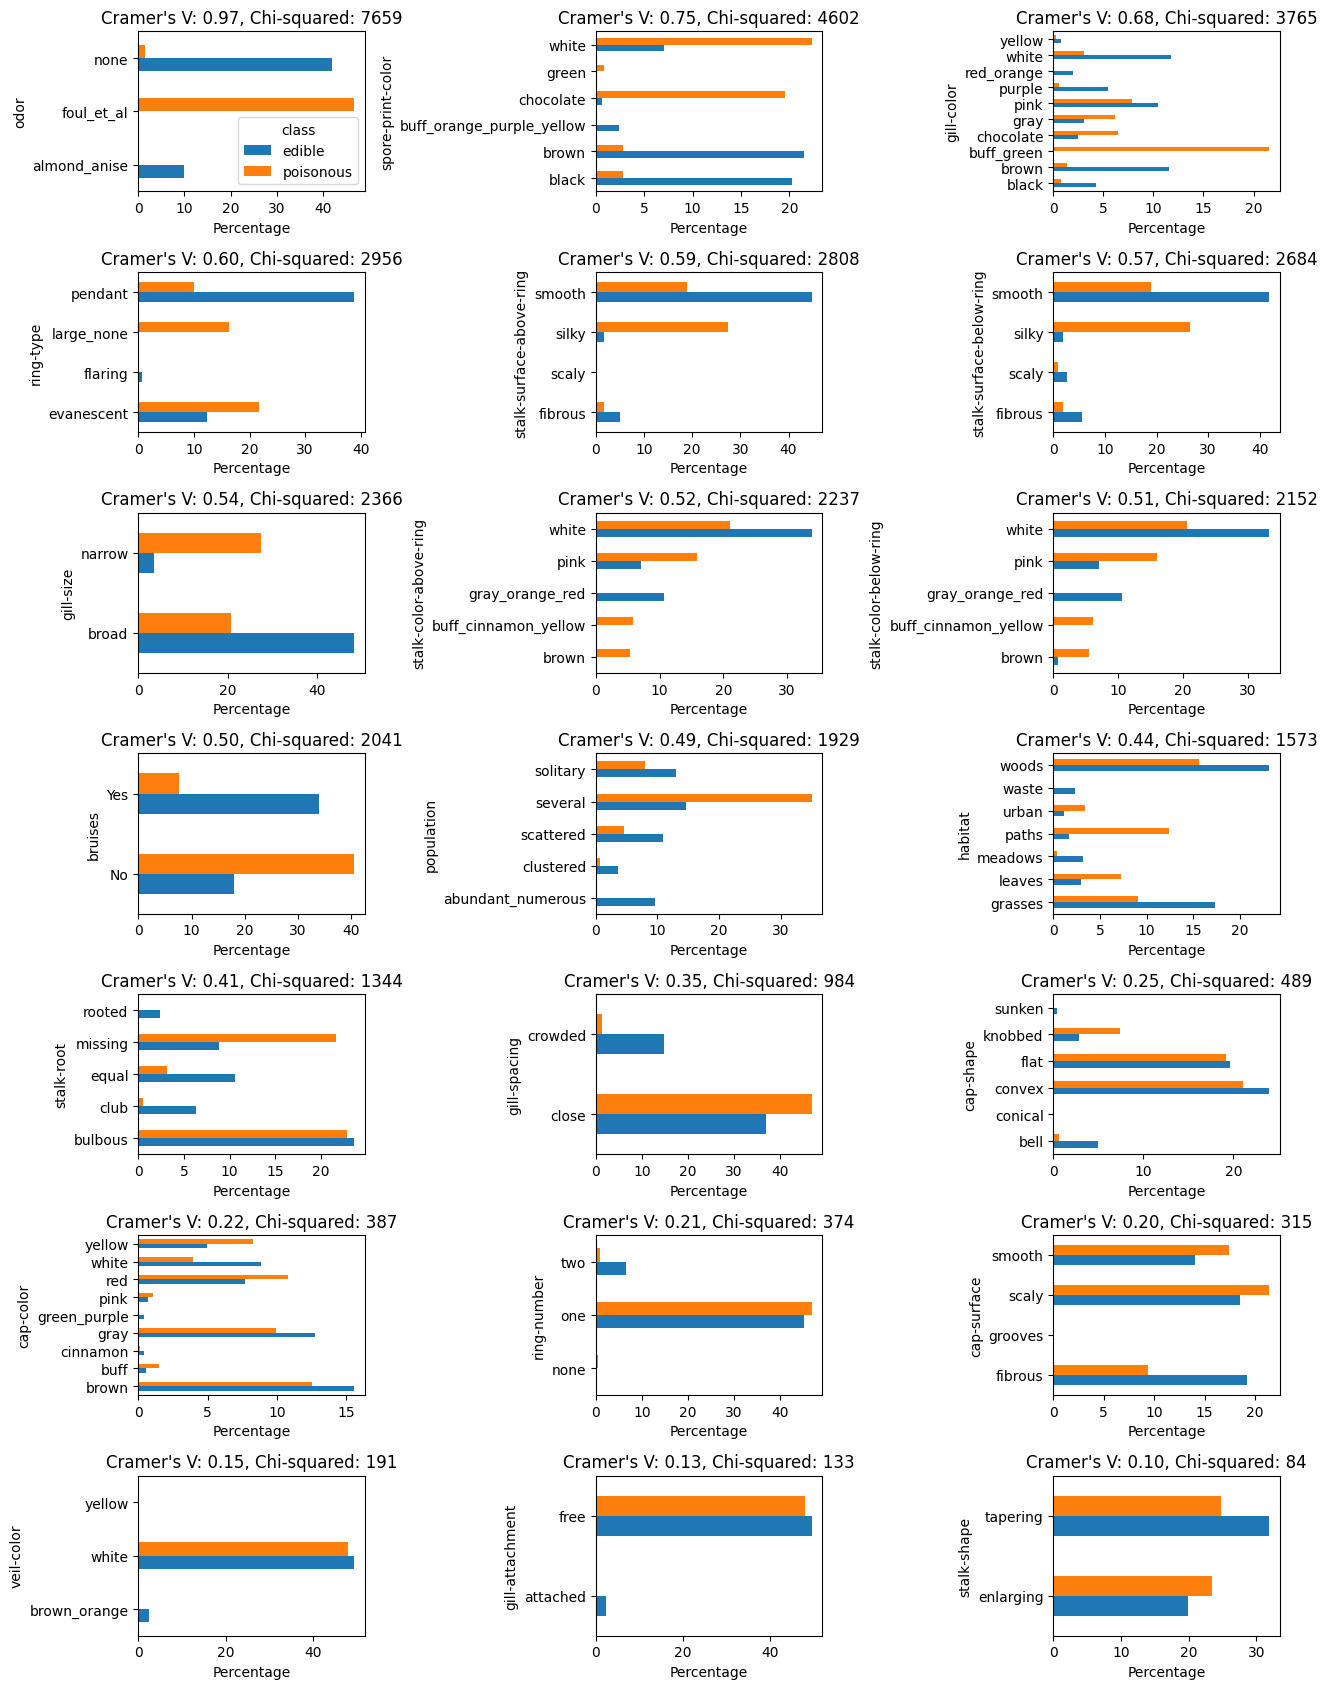

In [15]:
# Plot the crosstab of each feature, sorted by descending Cramer's V index
fig, axs = plt.subplots(7, 3, figsize=(13, 17), tight_layout=True)
axs = axs.ravel()
for index in range(21):
    descending_index = descending_indices[index] +1
    crosstab, chi_squared, cramer_v = get_crosstab_chisquared_crammerv(df.iloc[:, 0], df.iloc[:, descending_index])
    barplot = (100*crosstab/df.shape[0]).T.plot.barh(ax=axs[index], legend=index==0)
    axs[index].set_xlabel('Percentage')
    axs[index].set_title('Cramer\'s V: {:.2f}, Chi-squared: {}'.format(cramer_v, int(chi_squared)))

In [16]:
# Selection of the most relevant features, that is, Cramer's index superior to 0.5
df2 = pd.DataFrame()
df2['class'] = df['class']
df2['odor'] = df['odor']
df2['spore-print-color'] = df['spore-print-color']
df2['gill-color'] = df['gill-color']
df2['ring-type'] = df['ring-type']
df2['stalk-surface-above-ring'] = df['stalk-surface-above-ring']
df2['stalk-surface-below-ring'] = df['stalk-surface-below-ring']
df2['stalk-color-above-ring'] = df['stalk-color-above-ring']
df2['stalk-color-below-ring'] = df['stalk-color-below-ring']

### 3.4) Suppression of a dubious feature

&#x1F6A8; **We decide to suppress the feature `odor` for the following reasons:**
* The feature values are suspicious. The vast majority of `edible` mushrooms are reported to have an odor of `none`, which seems unrealistic (most mushrooms have a distinct smell). The vast majority of `poisonous` mushrooms are reported to have an odor of `fool` or `fishy`, which seems vague and strongly biased towards the class.
* The distribution of the feature values almost perfectly match the target class (see the crosstab plot on the top-left panel, with a Cramér's V index of 0.97). This could indicate that the values were biased by the knowledge of the class.
* The classification analysis of this dataset gives near-perfect results, with several different classifier models. Therefore, removing the feature most associated with the target class contributes to make the exercise more interesting and challenging (this does not reflect what a real-life application would necessitate).

In [17]:
# Good riddance
df2 = df2.drop('odor', axis=1)

### 3.5) Verification that the selected features are not too strongly associated with each others

&#x1F4A1; Here we verify that the features that we have selected are not too strongly associated with each others.

[Text(0, 0, 'class'),
 Text(0, 1, 'spore-print-color'),
 Text(0, 2, 'gill-color'),
 Text(0, 3, 'ring-type'),
 Text(0, 4, 'stalk-surface-above-ring'),
 Text(0, 5, 'stalk-surface-below-ring'),
 Text(0, 6, 'stalk-color-above-ring'),
 Text(0, 7, 'stalk-color-below-ring')]

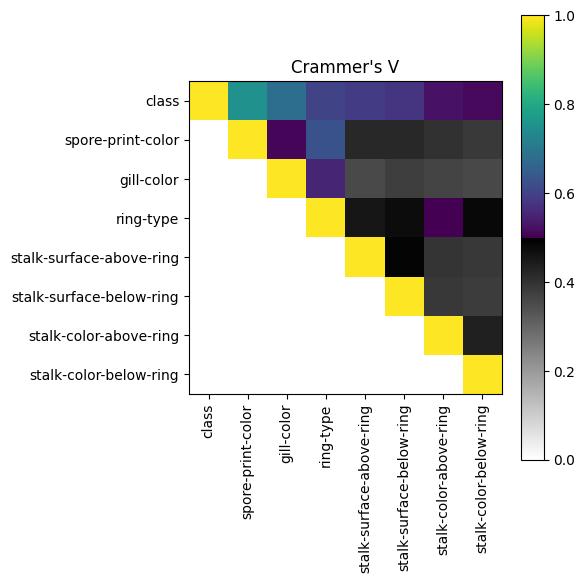

In [18]:
# Verify how selected features are correlated with each others
cramer_v = np.zeros((df2.shape[1], df2.shape[1]))

for index_a in range(df2.shape[1]):
    for index_b in range(index_a, df2.shape[1]):
        _, _, cramer_v[index_a, index_b] = get_crosstab_chisquared_crammerv(df2.iloc[:, index_a], df2.iloc[:, index_b])

colors_1 = plt.cm.binary(np.linspace(0, 1, 128))
colors_2 = plt.cm.viridis(np.linspace(0, 1, 128))
colors = np.vstack((colors_1, colors_2))
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)
plt.imshow(cramer_v, cmap=cmap)
plt.colorbar()
plt.title('Crammer\'s V')
ax.set_xticks(np.arange(df2.shape[1]))
ax.set_yticks(np.arange(df2.shape[1]))
ax.set_xticklabels(df2.keys(), rotation='vertical')
ax.set_yticklabels(df2.keys())

# 4) Preparation of the classification

Here we prepare the routines for the classification task. We implement a function to calculate quantitative metrics, we define functions to encode the categorical data, we instanciate a stratified K-fold, and we split the dataset into a train set and a test set.

### 4.1) Useful functions

In [19]:
def evaluate_metrics(y_reference, y_predicted):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_reference, y_predicted)
    metrics['precision'], metrics['recall'], metrics['f1score'], _ = precision_recall_fscore_support(y_reference, y_predicted, average='binary')
    return metrics

In [20]:
ohe = OneHotEncoder(drop='first')
le = LabelEncoder()

In [21]:
# Stratified K-Fold for grid-search optimization of the optimal model parameters
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

### 4.2) Construct the train and test datasets

In [22]:
X = df2.drop('class', axis=1)
y = df2['class'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=random_seed)

X_train = ohe.fit_transform(X_train)
y_train = le.fit_transform(y_train)

X_test = ohe.transform(X_test)
y_test = le.transform(y_test)

# 5) Classification

Here we present three different classification models: K-Nearest Neighbors, Random Forest, and Support Vector Machine.

### 5.1) Classification using a K-Nearest Neighbors model

In [23]:
# Define the model
model_knn = KNeighborsClassifier()

# Define the grid of parameters
params_grid = {
    'n_neighbors': [1, 5, 11, 13, 15, 17, 21, 25, 31],
    'weights': ['uniform', 'distance']
}

# Define a GridSearchCV to search the best parameters. Note that we optimize with respect to the f1 score.
grid_search = GridSearchCV(
    estimator=model_knn, param_grid=params_grid, scoring='f1', cv=skf, verbose=1)

In [24]:
# Search the best parameters with training data
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(best_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'n_neighbors': 13, 'weights': 'uniform'}


&#x1F4A1; We find that the optimal parameters are the following:

`{'n_neighbors': 13, 'weights': 'uniform'}`

In [25]:
# We parametrize the model using the optimal parameters
model_knn = KNeighborsClassifier(n_neighbors=13, weights='uniform')

# We fit the model on the train set
model_knn.fit(X_train, y_train)

# We evaluate the model on the test set
y_predicted = model_knn.predict(X_test)
metrics_array = evaluate_metrics(y_test, y_predicted)
print(metrics_array)

{'accuracy': 0.9499589827727646, 'precision': 0.9721973094170404, 'recall': 0.9225531914893617, 'f1score': 0.9467248908296944}


&#x1F4A1; We obtain excellent classification results:

`{'accuracy': 0.9499589827727646, 'precision': 0.9721973094170404, 'recall': 0.9225531914893617, 'f1score': 0.9467248908296944}`

### 5.2) Classification using a Random Forest

In [26]:
# Define the model
model_random_forest = RandomForestClassifier()

# Define the grid of parameters
params_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 7, 9, 11]
}

# Define a GridSearchCV to search the best parameters. Note that we optimize with respect to the f1 score.
grid_search = GridSearchCV(
    estimator=model_random_forest, param_grid=params_grid, scoring='f1', cv=skf, verbose=1)

In [27]:
# Search the best parameters with training data
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(best_params)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
{'criterion': 'gini', 'max_depth': 7}


&#x1F4A1; We find that the optimal parameters are the following:

`{'criterion': 'gini', 'max_depth': 7}`

In [28]:
# We parametrize the model using the optimal parameters
model_random_forest = RandomForestClassifier(criterion='gini', max_depth=7)

# We fit the model on the train set
model_random_forest.fit(X_train, y_train)

# We evaluate the model on the test set
y_predicted = model_random_forest.predict(X_test)
metrics_array = evaluate_metrics(y_test, y_predicted)
print(metrics_array)

{'accuracy': 0.9466776045939295, 'precision': 1.0, 'recall': 0.8893617021276595, 'f1score': 0.9414414414414415}


&#x1F4A1; We obtain excellent classification results:

`{'accuracy': 0.9466776045939295, 'precision': 1.0, 'recall': 0.8893617021276595, 'f1score': 0.9414414414414415}`

### 4.5) Classification using a Support Vector Machine

In [29]:
# Define the model
model_svm = SVC()

# Define the grid of parameters
params_grid = {
    'C': [1, 3, 5, 7, 10, 15],
    'kernel': ['poly', 'rbf', 'sigmoid']
}

# Define a GridSearchCV to search the best parameters. Note that we optimize with respect to the f1 score.
grid_search = GridSearchCV(
    estimator=model_svm, param_grid=params_grid, scoring='f1', cv=skf, verbose=1)

In [30]:
# Search the best parameters with training data
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(best_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'C': 3, 'kernel': 'poly'}


&#x1F4A1; We find that the optimal parameters are the following:

`{'C': 3, 'kernel': 'poly'}`

In [31]:
# We parametrize the model using the optimal parameters
model_svm = SVC(C=3, kernel='poly')

# We fit the model on the train set
model_svm.fit(X_train, y_train)

# We evaluate the model on the test set
y_predicted = model_svm.predict(X_test)
metrics_array = evaluate_metrics(y_test, y_predicted)
print(metrics_array)

{'accuracy': 0.9487284659557014, 'precision': 0.9637809187279152, 'recall': 0.9285106382978724, 'f1score': 0.9458170784568704}


&#x1F4A1; We obtain excellent classification results:

`{'accuracy': 0.9487284659557014, 'precision': 0.9637809187279152, 'recall': 0.9285106382978724, 'f1score': 0.9458170784568704}`

# 6) Results interpretation

&#x1F4A1; **Key findings from this investigation are the following:**
* Mushrooms from this dataset can be very well classified as being either `edible` or `toxic`, with an f1 score superior to 0.94 for all three models.
* The Support Vector Machine classifier obtains the highest recall score (0.93, also see the confusion matrices below), namely, this method is the best to correctly identify poisonous samples. Because of the danger associated with consuming toxic mushrooms, the Support Vector Machine should be the classifier selected for such analysis task.


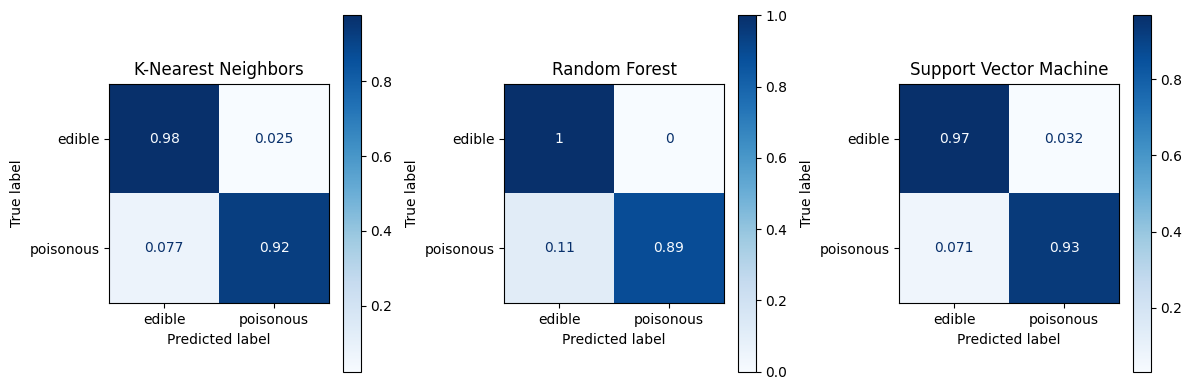

In [32]:
# We summarize the performance of all three classifiers by showing their associated confusion matrices
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

disp = ConfusionMatrixDisplay.from_estimator(
    model_knn,
    X_test,
    y_test,
    display_labels=le.classes_,
    cmap=plt.cm.Blues,
    normalize='true',
    ax=axs[0],
)
axs[0].set_title('K-Nearest Neighbors')

disp = ConfusionMatrixDisplay.from_estimator(
    model_random_forest,
    X_test,
    y_test,
    display_labels=le.classes_,
    cmap=plt.cm.Blues,
    normalize='true',
    ax=axs[1],
)
axs[1].set_title('Random Forest')

disp = ConfusionMatrixDisplay.from_estimator(
    model_svm,
    X_test,
    y_test,
    display_labels=le.classes_,
    cmap=plt.cm.Blues,
    normalize='true',
    ax=axs[2],
)
axs[2].set_title('Support Vector Machine')

plt.show()

# 7) Constructive criticism and possible further investigations

&#x1F4A1; Possible flaws in the model and a plan of action to revisit this analysis are the following:
* It is unspecified how many different mushroom species were used to construct the dataset (for both classes). It is therefore unsure if the model is able to correctly classify a species of mushroom it that was not included in the training dataset. **This is a major criticism of the approach and invalidates real-world applications.**
* We have identified one dubious feature (`odor`) and have p
* A flaw shared by all three models is the assumption that all features are independant. Although this hypothesis has been comforted by the inter-feature Cramér's index, a non-random association may still persist between some features. For instance, the surface below and above the ring are often distinct by may be associated in some cases. Idem for the color below and above the ring.
* It would be interesting to use a variation of this dataset with slightly richer labels to classify between `delicious`, `edible`, `toxic`, and `deadly` classes.
* It would be interesting to use a variation of this dataset with much richer labels to classify the latin name of each mushroom sample, from wich the edibility or toxicity can be derived.
* It would be meaningful to use a classification model based on probability distributions (namely, Bayesian statistics), to express results in a more nuanced way, while also providing built-in uncertainty quantification.

&#x1F344;